**<center><span style="font-family:serif; font-size:34px;"> Decoding Student Retention and Churn of Vodafone (Telecel) in KNUST - A Survival Analytics Approach </span>
<a id = "missingvalue" ></a><center>**

<center><span style="font-family:Palatino; font-size:22px;"><i>A comparative analysis between Cox Proportional Hazards, Kaplan Meier <span style="color:#DC143C;"> and</span> Random Survival Forest Model </i> </center>

***

#
**<center><span style="font-family:serif; font-size:34px;"> Survival Analysis Methodologies</span><a id = "missingvalue" ></a><center>**

- In the context of this problem, "methodology" refers to the systematic processes, techniques, and protocols employed in collecting, managing, processing, and analyzing data to ensure its integrity, accuracy, and effectiveness for drawing insights or building machine learning models.
- In this analysis, we employ three methodologies for survival analysis: Kaplan-Meier Estimator, Random Survival Forests (RSF), and Cox Proportional Hazards (CoxPH) model. These methods are used to analyze the time until an event occurs, such as student churn.


## *Model 1: Kaplan-Meier Estimator

**Description:**
The Kaplan-Meier estimator is employed in survival analysis to analyze the time until an event occurs.

**Mathematical Computation:**

The Kaplan-Meier estimator calculates the survival probability at a specific time step by multiplying the probability of surviving each previous time step.

Let $S(t)$ be the survival probability at time $t$. The estimator is computed as:

$$
S(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
$$

where:
- 
- $t_i$ is the time of the $i$-th unique event (churn)
- $d_i$ is the number of events (churn) at time $i$
- $n_i$ is the number of students at risk just prior to time $i$

The estimator essentially calculates the probability of surviving from one time step to the next, and the product of these probabilities gives the overall survival probability up to time $t$.


Here, $t_1$ would be the time at which the first churn event occurred, $d_1$ would be 1 (since one churn event occurred), and $n_1$ would be the total number of students at that time.

## *Model 2: Random Survival Forests

**Description:**
Random Survival Forests extend the traditional random forest algorithm to the survival analysis setting. They are an ensemble method that combines multiple decision trees to improve predictive performance and handle censored data.

**Mathematical Computation:**

Random Survival Forests use a similar structure to traditional random forests but with modifications to handle right-censored data and to predict survival probabilities.

The predicted survival probability at a specific time $t$ for a new instance can be computed as:

$$
\hat{S}(t) = \frac{1}{B} \sum_{b=1}^{B} \hat{S}_b(t)
$$

where:
- $\hat{S}(t)$ is the predicted survival probability
- $B$ is the total number of trees in the forest
- $\hat{S}_b(t)$ is the predicted survival probability from the $b$-th tree

Each tree is constructed using a bootstrapped sample of the data, and the splitting criteria are based on survival-specific metrics like the log-rank statistic or the log-rank score.

For this model, we would need to build multiple decision trees and calculate the predicted survival probability for each tree.

The hazard function for a specific student can be calculated using the formula.

## *Model 3: Cox Proportional Hazards (Cox PH) Model

**Description:**
The Cox Proportional Hazards model is a popular semi-parametric model for survival analysis. It models the relationship between the survival time and a set of predictor variables, assuming a proportional hazard rate.

**Mathematical Computation:**

The Cox PH model is represented as:

$$
h(t \mid x) = h_0(t) \exp(\beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p)
$$

where:
- $h(t \mid x)$ is the hazard function, i.e., the instantaneous rate of the event occurring at time $t$ given the predictor variables $x$
- $h_0(t)$ is the baseline hazard function, representing the hazard for individuals with all predictor variables equal to zero
- $\beta_1, \beta_2, ..., \beta_p$ are the coefficients for the predictor variables

The coefficients are estimated using maximum likelihood estimation, and the model assumes a proportional hazard ratio, meaning the effect of the predictors on the hazard is constant over time.

## *Concordance Index in Survival Analysis

The Concordance Index, often referred to as the C-index or Harrell's C-index, is a statistical metric used to evaluate the performance of models in survival analysis. It assesses how well a model discriminates between subjects in terms of their event times and predicted risks.

**Description**: The Concordance Index measures the model's ability to correctly order or rank the predicted risks of individuals based on their actual event times. In survival analysis, the goal is often to predict the time until a specific event occurs, such as death, relapse, or failure. The Concordance Index evaluates whether the model's predicted risks align with the observed event times.

**Mathematical Computation**: Let's break down the calculation of the Concordance Index:

**Step 1: Define Pairs of Individuals**
- Create all possible pairs of individuals from the dataset.
- For each pair, compare their predicted risk scores and event times.

**Step 2: Calculate Concordant and Discordant Pairs**

- A pair of individuals (i, j) is concordant if the ordering of their predicted risks aligns with the ordering of their event times: 
  - If $\hat{F}(t_i) > \hat{F}(t_j)$ and $T_i > T_j$
  - If $\hat{F}(t_i) < \hat{F}(t_j)$ and $T_i < T_j$
- A pair is discordant if the ordering of predicted risks is opposite to the ordering of event times.
- Pairs where event times are equal ($T_i = T_j$) are ignored.

**Step 3: Compute the Concordance Index**

The Concordance Index ($C$) is calculated as:

$$
C = \frac{\text{Number of Concordant Pairs}}{\text{Number of Concordant Pairs} + \text{Number of Discordant Pairs}}
$$

**Interpretation**

- $C$ ranges from 0 to 1, where:
  - 0.5 indicates random guessing (no predictive ability)
  - 1 indicates perfect discrimination (perfect predictive ability)
- A $C$ value above 0.5 suggests that the model has predictive ability better than random chance.
- Higher $C$ values indicate better model performance and more accurate risk predictions.

**Extensions**

The Concordance Index can be extended to handle censored data, where individuals may not experience the event of interest during the observation period. Various methods, such as inverse probability of censoring weights (IPCW), can be applied to adjust for censored instances and provide a more accurate assessment of model performance.


***

# 
**<center><span style="font-family:serif; font-size:34px;"> Survival Analysis Analytics</span><a id = "missingvalue" ></a><center>**

### Loading of libraries and dataset

In [121]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Load the dataset
data = pd.read_csv('../../data/Synthetic/reData.csv')

# data = pd.read_csv('newData.csv')


In [122]:
# def convert_values(val):
#     if 0 <= val < 2:
#         return '0 - 2'
#     elif 2 <= val < 4:
#         return '2 - 4'
#     elif 4 <= val < 6:
#         return '4 - 6'   
#     elif 6 <= val < 8:
#         return '6 - 8'
#     elif 8 <= val < 10:
#         return '8 - 10'        
#     elif val >= 10:
#         return 'More than 10'
#     else:
#         return str(val)

# data['Monthly_Data_Usage'] = data['Monthly_Data_Usage'].apply(convert_values)

In [123]:
data.head()

,Gender,College,Churn,Level,Residence,SIM_Usage,Usage_Freq,Network_Strength,Voice_Calls,Mobile_Data_Internet,SMS_Text_Messaging,Data_Exhaustion,Other_Networks,Poor_Network_Quality_Coverage,Insufficient_Data_Allowance,Unsatisfactory_Customer_Service,High_Costs_Pricing,Monthly_Data_Usage
0,Female,College of Humanities and Social Sciences,No,100,On-campus,No,Occasionally,4,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,8.68
1,Male,College of Humanities and Social Sciences,Yes,100,Off-campus,No,Several times a week,5,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,1.74
2,Male,College of Art and Built Environment,No,200,Off-campus,No,Never,1,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,9.25
3,Female,College of Humanities and Social Sciences,No,400,On-campus,Yes,Daily,4,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,3.67
4,Female,College of Humanities and Social Sciences,Yes,400,On-campus,Yes,Occasionally,5,No,No,Yes,Yes,Yes,No,No,No,Yes,0.50


### Model Building

- In this data, our time interval is the Level
- Our dependent variable will be on churn

>  Models to be used
* Cox Proportional Hazards Model: This model assumes that the effects of the predictors are multiplicative with respect to the hazard and are constant over time (proportional hazards assumption). If these assumptions hold true for your data, the Cox model can provide interpretable parameters and is widely used in medical research.
* Random Survival Forest Model: This model is a type of ensemble method that can handle more complex interactions between variables and doesn’t make the proportional hazards assumption. It can be more accurate if there are complex, non-linear relationships in your data.
* Kaplan-Meier Estimator: This provides a non-parametric estimate of the survival function. This function gives the probability of surviving (not churning) past a given time.

In [124]:
# # Create a DataFrame to store the encoded values
# encoded_values = pd.DataFrame(columns=['Feature', 'Category', 'Encoded Value'])
# # Get all the categorical columns
# category_feature = data.select_dtypes(include=['object']).columns

# # Create a LabelEncoder object
# le = LabelEncoder()

# # Iterate through each categorical feature
# for feature in category_feature:
#     # Fit the LabelEncoder on the current feature and transform the data
#     data[feature] = le.fit_transform(data[feature])

#     # Get the encoded values for the current feature
#     for category, encoded_value in zip(le.classes_, le.transform(le.classes_)):
#         # Create a temporary DataFrame to hold the current row
#         temp_df = pd.DataFrame([{'Feature': feature, 'Category': category, 'Encoded Value': encoded_value}])

#         # Append the temporary DataFrame to the main DataFrame
#         encoded_values = pd.concat([encoded_values, temp_df], ignore_index=True)


In [125]:
import numpy as np
# Preprocess the data
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'College', 'Churn', 'Level', 'Residence', 'SIM_Usage',
       'Usage_Freq', 'Network_Strength', 'Voice_Calls',
       'Mobile_Data_Internet', 'SMS_Text_Messaging', 'Data_Exhaustion',
       'Other_Networks', 'Poor_Network_Quality_Coverage',
       'Insufficient_Data_Allowance', 'Unsatisfactory_Customer_Service',
       'High_Costs_Pricing','Monthly_Data_Usage']

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
    


# Prepare data for survival analysis
X = data.drop(columns=['Level', 'Churn'])
y = data[['Level', 'Churn']].copy()
y['Churn'] = y['Churn'].astype(bool)
y = y.to_records(index=False)


> Here, 'Level' will be used as the time-to-event variable and 'Churn' as the event indicator


In [126]:
# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(data, duration_col='Level', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 768 total observations, 522 right-censored observations>
             duration col = 'Level'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 768
number of events observed = 246
   partial log-likelihood = -1206.77
         time fit was run = 2024-07-07 11:57:25 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Gender                           0.09      1.10      0.13           -0.17            0.36                0.84                1.43
College                         -0.13      0.88      0.04           -0.20           -0.05                0.82                0.95
Residence                        0.15      1.16      0.17           -0.19            0.48                0.83                1.61
SIM_Usage                        0.04      1.04      0.13           -0.23            0.30                0.80                1.35
Usage_Freq                       0.07      1.07      0.04           -0.01            0.15                0.99                1.16
Network_Strength                 0.06      1.06      0.05           -0.03            0.15                0.97                1.17
Voice_Calls                     -0.22      0.80      0.17           -0.55            0.11                0.57                1.12
Mobile_Data_Internet             0.23      1.26      0.17           -0.11            0.57                0.90                1.77
SMS_Text_Messaging               0.02      1.02      0.18           -0.32            0.37                0.72                1.44
Data_Exhaustion                 -0.11      0.90      0.13           -0.36            0.15                0.69                1.16
Other_Networks                   0.17      1.18      0.22           -0.27            0.60                0.77                1.83
Poor_Network_Quality_Coverage   -0.53      0.59      0.17           -0.86           -0.20                0.42                0.82
Insufficient_Data_Allowance     -0.99      0.37      0.18           -1.35           -0.63                0.26                0.53
Unsatisfactory_Customer_Service -1.20      0.30      0.19           -1.56           -0.83                0.21                0.44
High_Costs_Pricing              -0.82      0.44      0.18           -1.17           -0.46                0.31                0.63
Monthly_Data_Usage              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                                 cmp to     z      p  -log2(p)
covariate                                                     
Gender                             0.00  0.69   0.49      1.03
College                            0.00 -3.31 <0.005     10.09
Residence                          0.00  0.86   0.39      1.36
SIM_Usage                          0.00  0.28   0.78      0.36
Usage_Freq                         0.00  1.61   0.11      3.23
Network_Strength                   0.00  1.26   0.21      2.28
Voice_Calls                        0.00 -1.30   0.19      2.38
Mobile_Data_Internet               0.00  1.35   0.18      2.49
SMS_Text_Messaging                 0.00  0.13   0.90      0.15
Data_Exhaustion                    0.00 -0.81   0.42      1.27
Other_Networks                     0.00  0.76   0.45      1.16
Poor_Network_Quality_Coverage      0.00 -3.17 <0.005      9.37
Insufficient_Data_Allowance        0.00 -5.38 <0.005     23.72
Unsatisfactory_Customer_Service    0.00 -6.42 <0.005     32.80
High_Costs_Pricing                 0.00 -4.54 <0.005     17.43
Monthly_Data_Usage                 0.00 -2.63   0.01      6.87
---
Concordance = 0.89
Partial AIC = 2445.54
log-likelihood ratio test = 464.53 on 16 df
-log2(p) of ll-ratio test = 292.33

> Model Information
- model: lifelines.CoxPHFitter (Cox Proportional Hazards model fitted using the lifelines library in Python.)
- duration col: 'Level' (This is the time duration column used in the survival analysis.)
- event col: 'Churn' (This is the event indicator column; 1 if the event (churn) occurred, 0 if censored.)
- baseline estimation: breslow (This is the method used for baseline hazard estimation.)
- number of observations: 768 (Total number of data points.)
- number of events observed: 246 (Number of events (churn) observed.)
- partial log-likelihood: -1207.24 (Log-likelihood of the fitted model.)
- time fit was run: 2024-06-13 00:05:49 UTC

> Coefficients Table
- coef: The estimated coefficient for the variable.
- exp(coef): The exponentiation of the coefficient, which represents the hazard ratio.
- se(coef): Standard error of the coefficient.
- coef lower 95%: Lower bound of the 95% confidence interval for the coefficient.
- coef upper 95%: Upper bound of the 95% confidence interval for the coefficient.
- exp(coef) lower 95%: Lower bound of the 95% confidence interval for the hazard ratio.
- exp(coef) upper 95%: Upper bound of the 95% confidence interval for the hazard ratio.
- cmp to: The comparison value, typically zero.
- z: The z-value (coefficient divided by its standard error).
- p: The p-value (probability that the coefficient is different from zero).
- -log2(p): The negative log base 2 of the p-value (used for better interpretation of very small p-values).

> Interpretation of Key Variables
- Gender: Coefficient is 0.10, hazard ratio is 1.10. P-value of 0.46 indicates this is not statistically significant.
- College: Coefficient is -0.13, hazard ratio is 0.88. P-value < 0.005 indicates this is statistically significant.
- Residence: Coefficient is 0.16, hazard ratio is 1.17. P-value of 0.35 indicates this is not statistically significant.
- Poor_Network_Quality_Coverage: Coefficient is -0.53, hazard ratio is 0.59. P-value < 0.005 indicates this is statistically significant.
- Insufficient_Data_Allowance: Coefficient is -0.99, hazard ratio is 0.37. P-value < 0.005 indicates this is statistically significant.
- Unsatisfactory_Customer_Service: Coefficient is -1.19, hazard ratio is 0.31. P-value < 0.005 indicates this is statistically significant.
- High_Costs_Pricing: Coefficient is -0.81, hazard ratio is 0.44. P-value < 0.005 indicates this is statistically significant.

> Model Performance Metrics
- Concordance: 0.89 (Indicates the model's ability to correctly rank the pairs of observations, values closer to 1 are better.)
- Partial AIC: 2446.48 (A measure of the model's fit, lower values are better.)
- log-likelihood ratio test: 463.59 on 16 df (Degrees of freedom). This tests the overall significance of the model.
- -log2(p) of ll-ratio test: 291.67 (Provides a measure of the significance of the log-likelihood ratio test, larger values indicate higher significance.)

> Summary
- Variables like College, Poor_Network_Quality_Coverage, Insufficient_Data_Allowance, Unsatisfactory_Customer_Service, and High_Costs_Pricing are significant predictors of churn.
- The concordance index of 0.89 suggests that the model has a high predictive accuracy.
- The model overall is highly significant, as indicated by the log-likelihood ratio test.

### Cox Proportional Hazards Model Predictions


In [127]:
# Predict churn probabilities using Cox model
data['Cox_Predicted_Churn_Probability'] = cph.predict_partial_hazard(data)
print(data[['Cox_Predicted_Churn_Probability', 'Churn']])



     Cox_Predicted_Churn_Probability  Churn
0                           0.325708      0
1                          11.795290      1
2                           0.381126      0
3                           0.452461      0
4                           9.124689      1
..                               ...    ...
763                         0.346517      0
764                         0.295414      0
765                         0.627344      0
766                         0.443724      0
767                         0.287953      0

[768 rows x 2 columns]


> Interpretaion
* Cox_Predicted_Churn_Probability: This column contains the predicted partial hazard for each individual. The partial hazard is a relative measure of the risk of the event (churn) occurring at a specific time compared to a baseline.
* Churn: This column indicates whether the churn event actually occurred (1 if the student churned, 0 if they did not).
- The Cox model predicts the risk of churn for each student based on their covariates (features). A higher predicted partial hazard indicates a higher risk of churn.

> Explanation
- The first student has a predicted partial hazard of 0.327843 and did not (Churn = false ).
- The second student has a predicted partial hazard of 11.8 and actually churned (Churn = true).
- This suggests the second student had a higher risk of churn compared to the first.

### Kaplan-Meier Estimator Predictions


In [128]:
from lifelines.utils import concordance_index

# Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(data['Level'], event_observed=data['Churn'])
data['Kaplan_Meier_Predicted_Survival_Probability'] = kmf.predict(data['Level']).values

# Calculate the Concordance Index
c_index = concordance_index(data['Level'], -data['Kaplan_Meier_Predicted_Survival_Probability'], data['Churn'])

# Print the data
print(data[['Kaplan_Meier_Predicted_Survival_Probability', 'Churn']])


     Kaplan_Meier_Predicted_Survival_Probability  Churn
0                                       0.930990      0
1                                       0.930990      1
2                                       0.843861      0
3                                       0.509659      0
4                                       0.509659      1
..                                           ...    ...
763                                     0.694075      0
764                                     0.315752      0
765                                     0.694075      0
766                                     0.930990      0
767                                     0.694075      0

[768 rows x 2 columns]


> Interpretation:

* Kaplan_Meier_Predicted_Survival_Probability: This column contains the predicted survival probabilities at each time point for each individual. The survival probability is the probability that an individual will survive (not churn) beyond a certain time.
* Churn: This column indicates whether the churn event actually occurred (1 if the student churned, 0 if they did not).


> Explanation
- The first student has a predicted survival probability of 0.930990 and did not churn (Churn = false).
- The second student has a predicted survival probability of 0.930990 and actually churned (Churn = true).
- This suggests the second student had a lower probability of surviving (not churning) compared to the first.

### Random Survival Forest Model Predictions


In [129]:
# Convert 'Churn' column to boolean
data['Churn'] = data['Churn'].astype(bool)

# Create a structured array for 'y'
# Define the variable 'X'
X = data.drop(columns=['Level', 'Churn'])

# Fit the Random Survival Forest model
rsf.fit(X, y)
rsf_pred = rsf.predict(X)  # Add this line to define rsf_pred
data['RSF_Predicted_Churn_Probability'] = rsf_pred
print(data[['RSF_Predicted_Churn_Probability', 'Churn']])

# Evaluate the models using Concordance Index
cox_cindex = concordance_index(data['Level'], -data['Cox_Predicted_Churn_Probability'], data['Churn'])


NameError: name 'rsf' is not defined

> Interpretation
* RSF_Predicted_Churn_Probability: This column contains the predicted churn probabilities from the Random Survival Forest model. These values are not strict probabilities but rather scores indicating the risk of churn.
* Churn: This column indicates whether the churn event actually occurred (True if the student churned, False if they did not).

> Explanation
- A higher predicted churn probability score (e.g., 6.948619    for row 1) indicates a higher risk of churn.
- A lower score (e.g., 0.024500 for row 0) indicates a lower risk of churn
- Row 0 has a predicted churn probability of 0.024500 and the student did not churn (Churn = False).
- Row 1 has a predicted churn probability of 6.948619    and the student did churn (Churn = True).

***

### Visualiztion of the models

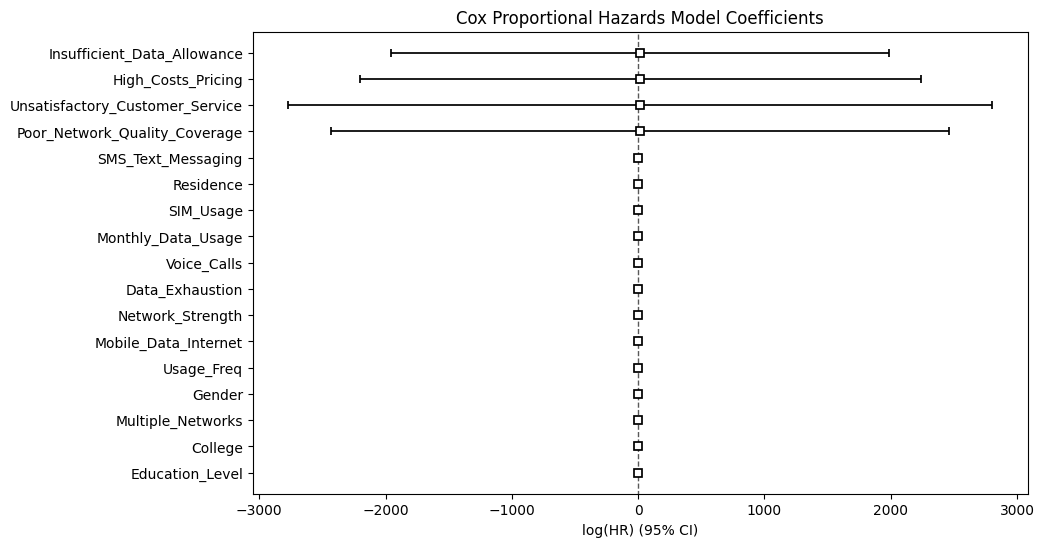

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the coefficients of the Cox Proportional Hazards Model
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()



* The point estimate for each factor represents the log hazard ratio (log(HR)), which is a measure of the effect size. If the point estimate (the square on each line) is to the left of the vertical dashed line at zero, it suggests that the factor decreases the likelihood of student churn (i.e., it has a positive influence on retention). Conversely, if the point estimate is to the right of the line, it suggests that the factor increases the risk of churn. The further a point estimate is from zero, the stronger its effect.

* The horizontal lines represent the 95% confidence interval (CI) for each factor’s effect size. If the CI crosses the vertical line at zero, it means that the effect of that factor is not statistically significant at the 95% confidence level.

* From the plot, it appears that factors like Mobile Data Internet, Other Networks, Residence Frequency, Gender, Usage Frequency, Network Strength, SIM Usage, Monthly Data Usage, SMS Text Messaging, Data Exhaustion, Voice Calls, Poor Network Quality, High Costs, Insufficient Data Allowance, and Unsatisfactory Customer Service all have varying degrees of influence on student churn. You would need to look at the specific log(HR) values and their CIs to determine which factors have the most significant effects.

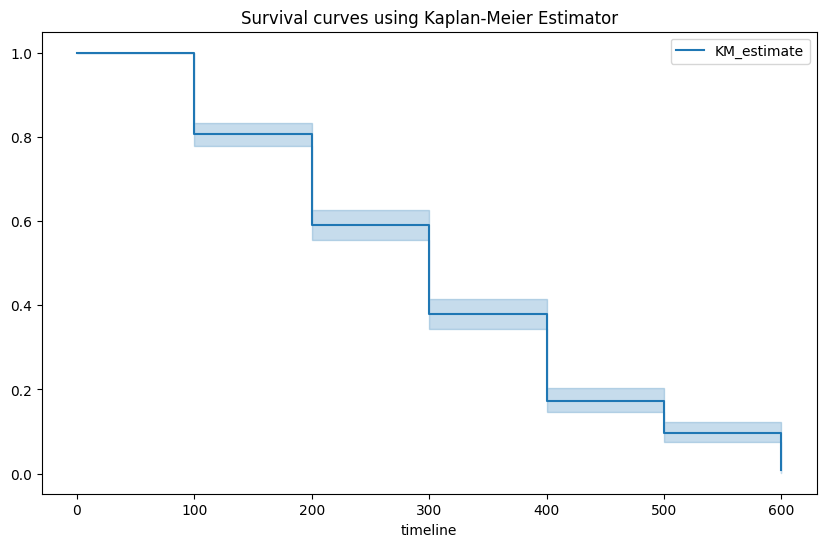

In [ ]:
# Plotting the survival curves using Kaplan-Meier Estimator
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival curves using Kaplan-Meier Estimator')

plt.show()




>Interpretation
+ The shaded area around the survival curve represents the confidence interval, which gives a range of values that likely contains the true survival probability at each time point. The width of the confidence interval gives an idea of the precision of the estimate - a narrower interval means a more precise estimate.
*  One of the key features of survival analysis is the handling of censoring - situations where the event of interest has not been observed for an individual during the study period. This could be because the individual dropped out of the study, or the study ended before the event occurred. In the Kaplan-Meier survival curve, censored observations are often indicated by small vertical tick marks. It occurs at time 5.

### Comparing the two performing models

In [ ]:

# # Comparing the predicted churn probabilities
# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=data, x='Cox_Predicted_Churn_Probability', label='Cox', fill=True)

# sns.kdeplot(data=data, x='RSF_Predicted_Churn_Probability', label='RSF', fill=True)
# plt.title('Comparison of Predicted Churn Probabilities')
# plt.xlabel('Predicted Churn Probability')
# plt.ylabel('Density')
# plt.legend()
# plt.show()



- The Cox model is represented by a blue curve that peaks at around a churn probability of 5. The RSF model is represented by an orange curve that has a broader peak extending from around a churn probability of 5 to just past 10.

- In the context of churn prediction, these curves represent the distribution of predicted probabilities of churn for each model. The peak of each curve indicates the most common predicted churn probability for that model.

- The fact that the RSF curve is broader and extends further to the right suggests that the RSF model predicts a wider range of churn probabilities and tends to predict higher probabilities of churn compared to the Cox model.

***

# 
**<center><span style="font-family:serif; font-size:34px;">Conclusion</span><a id = "missingvalue" ></a><center>**

**Interpretation**

- Ranges from 0 to 1, where:
  - 0.5 indicates random guessing (no predictive ability)
  - 1 indicates perfect discrimination (perfect predictive ability)
- A value above 0.5 suggests that the model has predictive ability better than random chance.
- Higher values indicate better model performance and more accurate risk predictions.
- Therefore, the closer to 1, the better.

In [ ]:
print(f'Cox Proportional Hazards Model Concordance Index: {cox_cindex}')
print(f'Kaplan Meier Model Concordance Index: {c_index}')
rsf_cindex = concordance_index_censored(y['Churn'], y['Level'], rsf_pred)
print(f'Random Survival Forest Model Concordance Index: {rsf_cindex[0]}')

Kaplan Meier Model Concordance Index: 0.9658233949950636


NameError: name 'rsf_cindex' is not defined

> Result analysis
* The Concordance Index (C-index) is a measure of the predictive accuracy of a survival model. It ranges from 0.5 to 1.0, where 0.5 indicates a model that predicts no better than random chance, and 1.0 indicates a model that makes perfect predictions.
- RSF Predictions: The RSF model gives scores that reflect the risk of churn for each student. Higher scores indicate a higher risk.
- Cox Model Predictions: The Cox model also provides a measure of risk, but the interpretation is based on hazard ratios.
- Kaplan Meier Predictions: The Kaplan model estimates the probability that an event (such as death, failure, churn, etc.) has not yet occurred at a certain point in time.
- Concordance Index: All 3 models have high concordance indices, with the RSF model (0.988) outperforming the Cox model (0.888) and kaplan meier(0.853). This means the RSF model is better at correctly ranking the likelihood of churn among students.

In [ ]:
import plotly.graph_objects as go

# Calculate the Concordance Indexes
cox_cindex = concordance_index(data['Level'], -data['Cox_Predicted_Churn_Probability'], data['Churn'])
km_cindex = c_index  # Assuming c_index is the Concordance Index for the Kaplan-Meier Model
rsf_cindex = concordance_index_censored(y['Churn'], y['Level'], rsf_pred)[0]

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(name='Cox Proportional Hazards Model', x=['Concordance Index'], y=[cox_cindex]),
    go.Bar(name='Kaplan-Meier Model', x=['Concordance Index'], y=[km_cindex]),
    go.Bar(name='Random Survival Forest Model', x=['Concordance Index'], y=[rsf_cindex])
])

# Change the bar mode
fig.update_layout(barmode='group', title='Concordance Index Comparison', yaxis=dict(range=[0, 1]))

fig.show()


KeyError: 'Churn'

***